In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('2022.csv')


In [3]:
df_all = pd.DataFrame()
for year in range(2015, 2024):
    df_year = pd.read_csv(f'{year}.csv')
    df_all = pd.concat([df_all, df_year])

In [4]:
import compute_rv
df = compute_rv.compute_re24(df)
df_all = compute_rv.compute_re24(df_all)
df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,runner_1b,runner_2b,runner_3b,runners,half_inning,bat_score_min,runs_scored_inning_total,runs_scored_rest_of_inning,re24,re24_change
0,4686,FF,2022-08-20,96.9,-1.13,6.48,"Bradish, Kyle",624414,680694,field_out,...,0,0,0,000,661043 1 Top,0,0,0,0.47,-0.24
1,4616,FF,2022-08-20,96.1,-1.46,6.37,"Bradish, Kyle",657077,680694,NaN,...,0,0,0,000,661043 1 Top,0,0,0,0.23,0.00
2,4392,FF,2022-08-20,95.4,-1.04,6.72,"Bradish, Kyle",657077,680694,NaN,...,0,0,0,000,661043 1 Top,0,0,0,0.23,0.00
3,4322,CU,2022-08-20,86.1,-1.28,6.52,"Bradish, Kyle",657077,680694,NaN,...,0,0,0,000,661043 1 Top,0,0,0,0.23,0.00
4,4102,FF,2022-08-20,96.6,-1.28,6.44,"Bradish, Kyle",657077,680694,field_out,...,0,0,0,000,661043 1 Top,0,0,0,0.23,-0.14


In [5]:
df.groupby('events')['re24_change'].mean()

events
catcher_interf                0.338621
caught_stealing_2b                 NaN
caught_stealing_3b                 NaN
caught_stealing_home               NaN
double                        0.750734
double_play                  -1.047895
field_error                   0.390265
field_out                    -0.238232
fielders_choice               0.693592
fielders_choice_out          -0.684554
force_out                    -0.338848
grounded_into_double_play    -0.896938
hit_by_pitch                  0.348771
home_run                      1.387745
other_out                          NaN
pickoff_1b                         NaN
pickoff_caught_stealing_2b         NaN
sac_bunt                     -0.027042
sac_fly                      -0.061478
sac_fly_double_play          -1.170000
single                        0.456800
strikeout                    -0.279833
strikeout_double_play        -0.909167
triple                        0.994000
triple_play                        NaN
walk              

In [6]:
mean_run_values = df.groupby('events')['re24_change'].mean()
df['mean_run_value'] = df['events'].map(mean_run_values)


In [7]:
mean_run_values = df_all.groupby('events')['re24_change'].mean()
df_all['mean_run_value'] = df_all['events'].map(mean_run_values)

In [8]:
df.groupby('events')['mean_run_value'].agg(['mean', 'std'])

,mean,std
events,,
catcher_interf,0.338621,0.0
caught_stealing_2b,NaN,NaN
caught_stealing_3b,NaN,NaN
caught_stealing_home,NaN,NaN
double,0.750734,0.0
double_play,-1.047895,0.0
field_error,0.390265,0.0
field_out,-0.238232,0.0
fielders_choice,0.693592,0.0


2022 run value leaders:

In [9]:
df.groupby(['player_name', 'pitcher'])['mean_run_value'].sum().sort_values().head(25)

player_name        pitcher
Gallen, Zac        668678    -31.286740
Javier, Cristian   664299    -18.953566
Bieber, Shane      669456    -18.835842
Cortes, Nestor     641482    -17.923083
deGrom, Jacob      594798    -17.672160
Ohtani, Shohei     660271    -17.532337
McKenzie, Triston  663474    -16.988364
Rasmussen, Drew    656876    -15.421682
Manoah, Alek       666201    -14.936888
Verlander, Justin  434378    -14.763768
Quantrill, Cal     615698    -14.350686
Scherzer, Max      453286    -14.350645
Anderson, Tyler    542881    -14.333164
Urías, Julio       628711    -14.156706
Luzardo, Jesús     666200    -13.775998
Darvish, Yu        506433    -13.737528
Cease, Dylan       656302    -13.695184
Rodón, Carlos      607074    -12.812586
Quintana, José     500779    -12.272034
Burnes, Corbin     669203    -12.270651
Strider, Spencer   675911    -11.782965
Germán, Domingo    593334    -11.780080
Alcantara, Sandy   645261    -11.735358
Herget, Jimmy      623474    -11.443772
Woodruff, Bra

In [10]:
df_gdp = df[df['events'] == 'grounded_into_double_play']
df_gdp_count = df_gdp.groupby(['player_name', 'pitcher']).size().reset_index(name='gdp_count')
df_new = pd.merge(df_all, df_gdp_count, on=['player_name', 'pitcher'], how='left')
df_new['gdp_count'] = df_new['gdp_count'].fillna(0)



2015-2023 re24 run value leaders:

In [11]:
df_new.groupby(['player_name', 'pitcher'])['mean_run_value'].sum().sort_values().head(20)

player_name         pitcher
deGrom, Jacob       594798    -267.901550
Scherzer, Max       453286    -266.690483
Kershaw, Clayton    477132    -265.487438
Verlander, Justin   434378    -231.045007
Cole, Gerrit        543037    -214.427595
Greinke, Zack       425844    -173.946314
Nola, Aaron         605400    -161.091447
Sale, Chris         519242    -150.912065
Kluber, Corey       446372    -143.999727
Strasburg, Stephen  544931    -142.699943
Wheeler, Zack       554430    -139.376951
Stroman, Marcus     573186    -131.153688
Hendricks, Kyle     543294    -125.793388
Snell, Blake        605483    -122.034697
Buehler, Walker     621111    -116.359128
Castillo, Luis      622491    -115.572272
Morton, Charlie     450203    -115.514814
Jansen, Kenley      445276    -114.063951
Gray, Sonny         543243    -113.454947
Darvish, Yu         506433    -113.122936
Name: mean_run_value, dtype: float64

In [12]:
df_all.groupby(['player_name', 'pitcher'])['re24_change'].sum().sort_values().head(25)

player_name         pitcher
Bautista, Félix     642585    -8.45
Hader, Josh         623352    -4.13
Maddox, Austin      545348    -3.70
Suarez, Robert      663158    -3.26
Frías, Carlos       516910    -2.78
Duran, Jhoan        661395    -2.67
Hinojosa, Dalier    648737    -2.54
Barrios, Yhonathan  553872    -2.30
Felipe, Angel       665734    -2.23
McGee, Easton       668834    -2.20
Martín, Rafael      514669    -2.04
Morrow, Brandon     453344    -1.98
Abbott, Andrew      671096    -1.87
Baz, Shane          669358    -1.87
Vásquez, Randy      681190    -1.78
Castillo, Luis      622379    -1.55
Cosgrove, Tom       676680    -1.34
De Jesus, Angel     669804    -1.27
Rodriguez, Elvin    660730    -1.23
Hancock, Justin     606995    -1.20
Neuse, Sheldon      641914    -1.20
Gose, Anthony       543238    -1.13
Griffin, Foster     656492    -1.10
Mejia, Jenrry       516769    -1.09
Simmons, Shae       623406    -1.03
Name: re24_change, dtype: float64

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
df_all_bip = df_all.dropna(subset=['launch_speed', 'launch_angle', 'mean_run_value'])

X = df_all_bip[['launch_speed', 'launch_angle']]
y = df_all_bip['mean_run_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=250, n_jobs=-1)
knn.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=250)

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = knn.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('R2 score: %.2f' % r2_score(y_test, y_pred))


Mean squared error: 0.14
R2 score: 0.43


In [22]:
df['pred_run_value'] = np.nan
mask = df[['launch_speed', 'launch_angle']].notna().all(axis=1)
df.loc[mask, 'pred_run_value'] = knn.predict(df.loc[mask, ['launch_speed', 'launch_angle']])

events_to_update = ['walk', 'hit_by_pitch', 'strikeout', 'strikeout_double_play']

mean_run_values_df = df.groupby('events')['re24_change'].mean().to_dict()
mean_run_values_df_all = df_all.groupby('events')['re24_change'].mean().to_dict()

for event in events_to_update:
    mask = (df['events'] == event)
    df.loc[mask, 'pred_run_value'] = mean_run_values_df[event]
    
    mask_all = (df_all['events'] == event)
    df_all.loc[mask_all, 'pred_run_value'] = mean_run_values_df_all[event]


2021 predicted run value leaders:

In [24]:
df_all.loc[df_all['game_year'] == 2021].groupby(['player_name', 'pitcher'])['pred_run_value'].sum().sort_values().head(20)

player_name        pitcher
Cole, Gerrit       543037    -55.912658
Wheeler, Zack      554430    -54.835160
Burnes, Corbin     669203    -54.193286
Scherzer, Max      453286    -53.849057
Ray, Robbie        592662    -53.202038
Nola, Aaron        605400    -48.773939
Gausman, Kevin     592332    -48.140589
Woodruff, Brandon  605540    -44.973719
Eovaldi, Nathan    543135    -43.015617
Buehler, Walker    621111    -42.859888
Urías, Julio       628711    -42.385520
Giolito, Lucas     608337    -41.064033
Berríos, José      621244    -40.704778
Darvish, Yu        506433    -40.671631
Montas, Frankie    593423    -40.266108
Cease, Dylan       656302    -40.180568
Manaea, Sean       640455    -39.533973
Rodón, Carlos      607074    -39.187623
Alcantara, Sandy   645261    -38.993217
Morton, Charlie    450203    -38.084906
Name: pred_run_value, dtype: float64

2022 predicted run value leaders:

In [23]:
df.groupby(['player_name', 'pitcher'])['pred_run_value'].sum().sort_values().head(20)

player_name        pitcher
Gallen, Zac        668678    -30.429919
Alcantara, Sandy   645261    -29.126842
deGrom, Jacob      594798    -27.894529
Rasmussen, Drew    656876    -26.575954
Scherzer, Max      453286    -26.265449
Javier, Cristian   664299    -26.074465
Verlander, Justin  434378    -25.337232
Lynn, Lance        458681    -25.123722
Suarez, José       660761    -24.980738
Strider, Spencer   675911    -24.827173
Snell, Blake       605483    -24.249472
McKenzie, Triston  663474    -24.006615
Gausman, Kevin     592332    -23.829050
Kirby, George      669923    -23.440450
Wright, Kyle       657140    -22.651879
Springs, Jeffrey   605488    -22.562000
Webb, Logan        657277    -22.280698
Ray, Robbie        592662    -21.298655
Urías, Julio       628711    -21.296585
Castillo, Luis     622491    -21.220939
Name: pred_run_value, dtype: float64

2023 predicted run value leaders:

In [35]:
df_all.loc[df_all['game_year'] == 2023].groupby(['player_name', 'pitcher'])['pred_run_value'].sum().sort_values().head(50)

player_name         pitcher
Strider, Spencer    675911    -45.473791
Gausman, Kevin      592332    -39.240130
Ryan, Joe           657746    -34.158123
López, Pablo        641154    -33.856257
Gallen, Zac         668678    -32.766658
Webb, Logan         657277    -32.585047
Wheeler, Zack       554430    -31.755062
Cole, Gerrit        543037    -31.470068
Castillo, Luis      622491    -31.403292
Luzardo, Jesús      666200    -29.646439
Eflin, Zach         621107    -29.425553
Kirby, George       669923    -28.613845
Nola, Aaron         605400    -28.165633
Valdez, Framber     664285    -27.907704
Gilbert, Logan      669302    -27.803172
Lynn, Lance         458681    -26.895896
Keller, Mitch       656605    -26.656245
Garrett, Braxton    666129    -26.208617
Scherzer, Max       453286    -26.089283
Ohtani, Shohei      660271    -25.983297
Giolito, Lucas      608337    -24.122673
Peralta, Freddy     642547    -23.269036
Cease, Dylan        656302    -22.757301
Snell, Blake        605483   

In [27]:
df_all.loc[df_all['game_year'].isin([2021, 2022, 2023])].groupby(['player_name', 'pitcher'])['pred_run_value'].sum().sort_values().head(20)

player_name       pitcher
Gausman, Kevin    592332    -106.272530
Cole, Gerrit      543037    -103.999494
Scherzer, Max     453286     -94.688355
Wheeler, Zack     554430     -94.544014
Nola, Aaron       605400     -93.627289
Burnes, Corbin    669203     -90.755457
Lynn, Lance       458681     -78.381602
Castillo, Luis    622491     -77.160198
Darvish, Yu       506433     -76.335680
Gallen, Zac       668678     -75.348006
Giolito, Lucas    608337     -75.137763
deGrom, Jacob     594798     -75.038524
Alcantara, Sandy  645261     -74.136795
Webb, Logan       657277     -73.493402
Cease, Dylan      656302     -72.703902
Morton, Charlie   450203     -68.607287
Urías, Julio      628711     -67.683494
Snell, Blake      605483     -67.575626
Berríos, José     621244     -66.860029
Eovaldi, Nathan   543135     -66.323056
Name: pred_run_value, dtype: float64

In [32]:
df_all = df_all.sort_values(['game_year', 'game_pk', 'inning', 'at_bat_number', 'pitch_number'])
df_all['outs_on_play'] = df_all.groupby(['inning', 'inning_topbot'])['outs_when_up'].add().shift(-1)
df_all['outs_on_play'] = df_all['outs_on_play'].fillna(0)


In [34]:
df_all.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,runners,half_inning,bat_score_min,runs_scored_inning_total,runs_scored_rest_of_inning,re24,re24_change,mean_run_value,pred_run_value,outs_on_play
0,4800.0,FF,2015-07-22,89.4,2.64,5.42,"Cingrani, Tony",451594,571561,NaN,...,000,413902 1 Top,0,0,0,0.51,0.00,NaN,NaN,0.0
1,4645.0,FF,2015-07-22,89.4,2.37,5.46,"Cingrani, Tony",451594,571561,NaN,...,000,413902 1 Top,0,0,0,0.51,0.00,NaN,NaN,0.0
2,4486.0,SL,2015-07-22,80.8,2.69,5.39,"Cingrani, Tony",451594,571561,double,...,000,413902 1 Top,0,0,0,0.51,0.62,0.75195,NaN,0.0
3,4314.0,FF,2015-07-22,90.9,2.49,5.49,"Cingrani, Tony",516770,571561,NaN,...,010,413902 1 Top,0,0,0,1.13,0.00,NaN,NaN,0.0
4,4142.0,FF,2015-07-22,90.9,2.50,5.54,"Cingrani, Tony",516770,571561,NaN,...,010,413902 1 Top,0,0,0,1.13,0.00,NaN,NaN,0.0


In [33]:
df_all.groupby('events')['outs_on_play'].mean()

events
catcher_interf                  0.000000
caught_stealing_2b             -1.940467
caught_stealing_3b             -1.928571
caught_stealing_home           -1.938776
double                         -0.009078
double_play                    -0.572419
ejection                       -2.000000
field_error                    -0.008564
field_out                       0.007937
fielders_choice                -0.019163
fielders_choice_out             0.886702
force_out                      -0.118796
game_advisory                  -2.000000
grounded_into_double_play      -0.370841
hit_by_pitch                   -0.001068
home_run                       -0.024099
intent_walk                     0.000000
other_out                      -1.952569
passed_ball                    -1.857143
pickoff_1b                     -1.950820
pickoff_2b                     -1.928571
pickoff_3b                     -1.923077
pickoff_caught_stealing_2b     -1.850000
pickoff_caught_stealing_3b     -2.000000
pickoff_c

In [46]:
from pybaseball import pitching_stats_bref

pitchers_2023 = pitching_stats_bref(2023)
pitchers_2023 = pitchers_2023.loc[:, ['Tm', 'IP', 'ER', 'ERA', 'GDP', 'BB', 'SO', 'BF', 'mlbID']]
pitchers_2023['mlbID'] = pitchers_2023['mlbID'].astype('int64')
pitchers_2023.head()


,Tm,IP,ER,ERA,GDP,BB,SO,BF,mlbID
1,Colorado,6.1,3,4.26,2,3,2,32,472551
2,Cincinnati,81.1,27,2.99,3,27,88,327,671096
3,Washington,26.2,15,5.06,4,15,24,121,676265
4,New York,51.0,27,4.76,3,30,54,228,656061
5,Houston,56.0,14,2.25,4,26,81,231,650556


In [50]:
leaders_23 = df_all.loc[df_all['game_year'] == 2023].groupby(['player_name', 'pitcher'], as_index=False)['pred_run_value'].sum().sort_values(by='pred_run_value').round(1)

In [51]:
df_23 = pd.merge(leaders_23, pitchers_2023, left_on='pitcher', right_on='mlbID')
df_23.head()

,player_name,pitcher,pred_run_value,Tm,IP,ER,ERA,GDP,BB,SO,BF,mlbID
0,"Strider, Spencer",675911,-45.5,Atlanta,139.1,58,3.75,5,45,217,572,675911
1,"Gausman, Kevin",592332,-39.2,Toronto,144.1,52,3.24,7,37,187,590,592332
2,"Ryan, Joe",657746,-34.2,Minnesota,126.0,62,4.43,5,25,152,523,657746
3,"López, Pablo",641154,-33.9,Minnesota,147.2,60,3.66,6,37,180,600,641154
4,"Gallen, Zac",668678,-32.8,Arizona,155.2,56,3.24,13,32,165,620,668678


In [57]:
df_23['xRV/BF'] = df_23['pred_run_value'].div(df_23['BF']).round(3)

In [59]:
df_23.loc[df_23['IP'] > 100].sort_values(by='xRV/BF').head(20)

,player_name,pitcher,pred_run_value,Tm,IP,ER,ERA,GDP,BB,SO,BF,mlbID,xRV/BF
0,"Strider, Spencer",675911,-45.5,Atlanta,139.1,58,3.75,5,45,217,572,675911,-0.080
1,"Gausman, Kevin",592332,-39.2,Toronto,144.1,52,3.24,7,37,187,590,592332,-0.066
2,"Ryan, Joe",657746,-34.2,Minnesota,126.0,62,4.43,5,25,152,523,657746,-0.065
3,"López, Pablo",641154,-33.9,Minnesota,147.2,60,3.66,6,37,180,600,641154,-0.056
10,"Eflin, Zach",621107,-29.4,Tampa Bay,132.1,54,3.67,9,18,132,524,621107,-0.056
4,"Gallen, Zac",668678,-32.8,Arizona,155.2,56,3.24,13,32,165,620,668678,-0.053
6,"Wheeler, Zack",554430,-31.8,Philadelphia,144.0,58,3.63,4,29,160,596,554430,-0.053
28,"Kershaw, Clayton",477132,-21.8,Los Angeles,105.1,29,2.48,12,26,111,416,477132,-0.052
8,"Castillo, Luis",622491,-31.4,Seattle,150.1,54,3.23,2,37,166,607,622491,-0.052
17,"Garrett, Braxton",666129,-26.2,Miami,122.0,53,3.91,10,21,126,507,666129,-0.052


In [60]:
df_23.corr()

C:\Users\wampl\AppData\Local\Temp\ipykernel_18796\3497080820.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_23.corr()


,pitcher,pred_run_value,IP,ER,ERA,GDP,BB,SO,BF,mlbID,xRV/BF
pitcher,1.000000,0.115377,-0.146017,-0.138670,0.008183,-0.114508,-0.110268,-0.125412,-0.145594,1.000000,0.003148
pred_run_value,0.115377,1.000000,-0.875214,-0.722386,0.209193,-0.645037,-0.679303,-0.948609,-0.856226,0.115377,0.478382
IP,-0.146017,-0.875214,1.000000,0.917818,-0.214395,0.837321,0.877510,0.958587,0.997699,-0.146017,-0.311504
ER,-0.138670,-0.722386,0.917818,1.000000,-0.108936,0.761209,0.851615,0.844173,0.936508,-0.138670,-0.198505
ERA,0.008183,0.209193,-0.214395,-0.108936,1.000000,-0.181183,-0.187143,-0.219845,-0.204343,0.008183,0.372198
GDP,-0.114508,-0.645037,0.837321,0.761209,-0.181183,1.000000,0.749957,0.751547,0.835340,-0.114508,-0.188527
BB,-0.110268,-0.679303,0.877510,0.851615,-0.187143,0.749957,1.000000,0.865371,0.893832,-0.110268,-0.196416
SO,-0.125412,-0.948609,0.958587,0.844173,-0.219845,0.751547,0.865371,1.000000,0.952292,-0.125412,-0.393070
BF,-0.145594,-0.856226,0.997699,0.936508,-0.204343,0.835340,0.893832,0.952292,1.000000,-0.145594,-0.294063
mlbID,1.000000,0.115377,-0.146017,-0.138670,0.008183,-0.114508,-0.110268,-0.125412,-0.145594,1.000000,0.003148


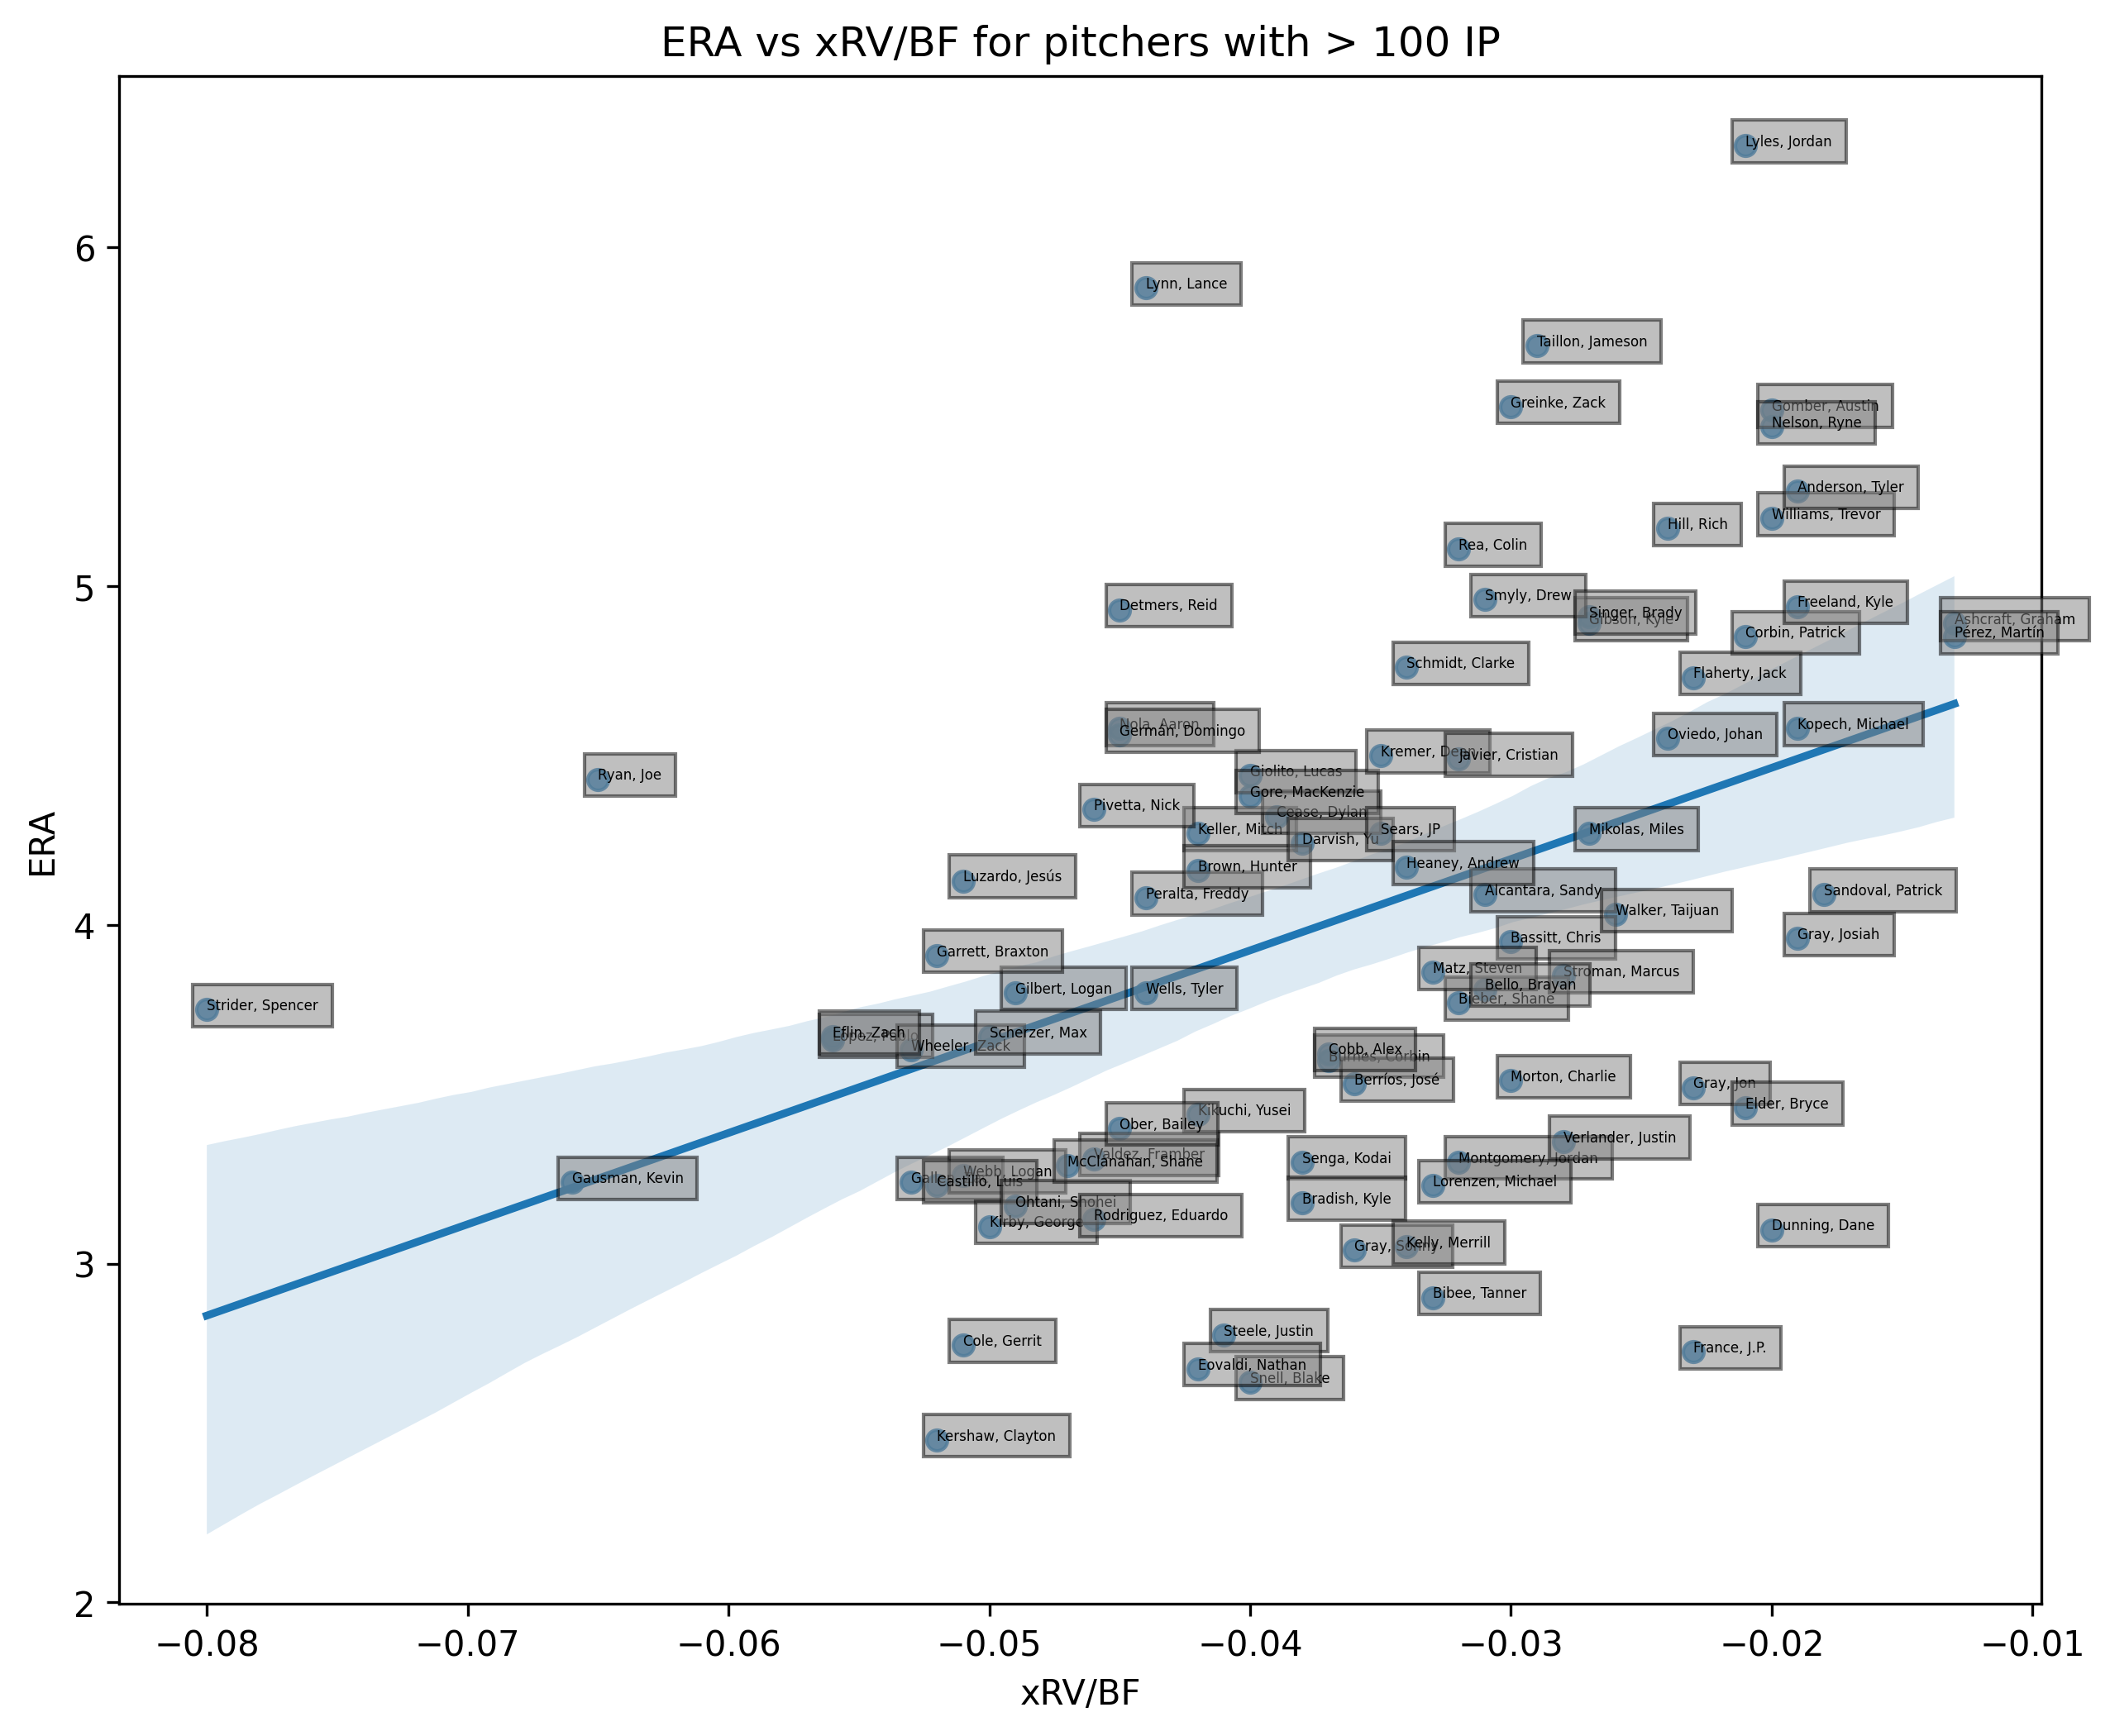

In [69]:

df_100 = df_23[df_23['IP'] > 100]

plt.figure(figsize=(10, 8), dpi=300)
sns.regplot(x='xRV/BF', y='ERA', data=df_100)

for i in range(df_100.shape[0]):
    plt.text(x=df_100['xRV/BF'].iloc[i],
     y=df_100['ERA'].iloc[i],
      s=df_100['player_name'].iloc[i],
       fontdict=dict(color='black',size=4),
        bbox=dict(facecolor='gray',alpha=0.5))

plt.xlabel('xRV/BF')
plt.ylabel('ERA')
plt.title('ERA vs xRV/BF for pitchers with > 100 IP')
plt.show()




In [140]:
import plotly.express as px

df_100 = df_23[df_23['IP'] > 20]

fig = px.scatter(df_100, x='xRV/BF', y='ERA', trendline='ols', hover_name='player_name', hover_data=['IP', 'ERA', 'xRV/BF'])

fig.update_layout(
    title='ERA vs xRV/BF for pitchers with > 100 IP',
    xaxis_title='xRV/BF',
    yaxis_title='ERA'
)

fig.show()

In [74]:
from pybaseball import pitching_stats

xERA_data_2023 = pitching_stats(2022, 2023)
xERA_data_2023.head()


,IDfg


In [91]:
df_all.loc[df_all['events'] == 'walk', 'estimated_woba_using_speedangle'] = 0.7
df_all.loc[df_all['events'] == 'intentional_walk', 'estimated_woba_using_speedangle'] = 0.7
df_all.loc[df_all['events'] == 'hit_by_pitch', 'estimated_woba_using_speedangle'] = 0.7
df_all.loc[df_all['events'] == 'strikeout', 'estimated_woba_using_speedangle'] = 0
df_all.loc[df_all['events'] == 'strikeout_double_play', 'estimated_woba_using_speedangle'] = 0


In [95]:
xera = df_all.loc[df_all['game_year']==2023].groupby(['player_name', 'pitcher'], as_index=False)['estimated_woba_using_speedangle'].mean()

In [96]:
xera

,player_name,pitcher,estimated_woba_using_speedangle
0,"Abad, Fernando",472551,0.433188
1,"Abbott, Andrew",671096,0.294709
2,"Abbott, Cory",676265,0.329962
3,"Abreu, Albert",656061,0.314297
4,"Abreu, Bryan",650556,0.276379
...,...,...,...
775,"Zastryzny, Rob",642239,0.337580
776,"Zerpa, Angel",672582,0.497500
777,"Zimmermann, Bruce",669145,0.315491
778,"Zuñiga, Guillermo",670871,0.371333


In [97]:
er_per_ip_23 = 15442/32175

In [98]:
xwoba_mean = xera['estimated_woba_using_speedangle'].mean()

In [120]:
xera['xERA'] = round(9 * (er_per_ip_23 * ((xera['estimated_woba_using_speedangle'].div(0.321))**2)), 2)

In [121]:
xera

,player_name,pitcher,estimated_woba_using_speedangle,xERA
0,"Abad, Fernando",472551,0.433188,7.87
1,"Abbott, Andrew",671096,0.294709,3.64
2,"Abbott, Cory",676265,0.329962,4.56
3,"Abreu, Albert",656061,0.314297,4.14
4,"Abreu, Bryan",650556,0.276379,3.20
...,...,...,...,...
775,"Zastryzny, Rob",642239,0.337580,4.78
776,"Zerpa, Angel",672582,0.497500,10.38
777,"Zimmermann, Bruce",669145,0.315491,4.17
778,"Zuñiga, Guillermo",670871,0.371333,5.78


In [130]:
mean_pred_run_value = df_23['pred_run_value'].sum() / df_23['BF'].sum()
mean_pred_run_value

-0.03182017255726361

In [123]:
df_23['xERA+'] = round(9 * (er_per_ip_23 * ((df_23['xRV/BF'].div(mean_pred_run_value))**2)), 2)


In [124]:
df_23 = pd.merge(df_23, xera[['player_name', 'pitcher', 'xERA']], on=['player_name', 'pitcher'], how='left')
df_23.head()


,player_name,pitcher,pred_run_value,Tm,IP,ER,ERA,GDP,BB,SO,BF,mlbID,xRV/BF,xERA+,xERA_x,xERA_y,xERA
0,"Strider, Spencer",675911,-45.5,Atlanta,139.1,58,3.75,5,45,217,572,675911,-0.080,27.30,2.88,3.21,3.15
1,"Gausman, Kevin",592332,-39.2,Toronto,144.1,52,3.24,7,37,187,590,592332,-0.066,18.58,3.39,3.78,3.71
2,"Ryan, Joe",657746,-34.2,Minnesota,126.0,62,4.43,5,25,152,523,657746,-0.065,18.02,3.02,3.37,3.30
3,"López, Pablo",641154,-33.9,Minnesota,147.2,60,3.66,6,37,180,600,641154,-0.056,13.38,2.98,3.32,3.25
4,"Gallen, Zac",668678,-32.8,Arizona,155.2,56,3.24,13,32,165,620,668678,-0.053,11.98,3.61,4.02,3.95


<AxesSubplot: >

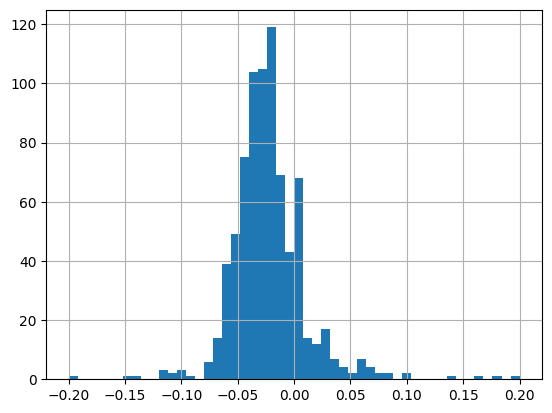

In [126]:
df_23['xRV/BF'].hist(bins=50)

<AxesSubplot: >

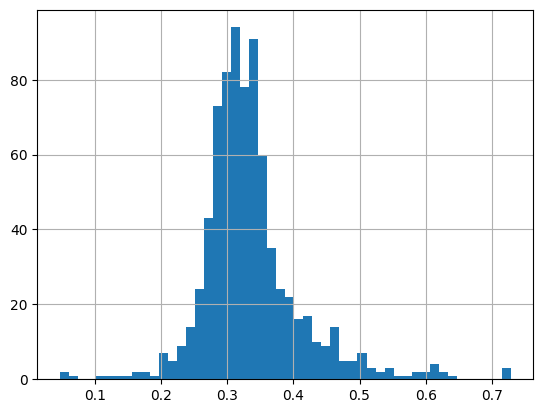

In [129]:
xera['estimated_woba_using_speedangle'].hist(bins=50)

In [141]:
df_23.corr()

C:\Users\wampl\AppData\Local\Temp\ipykernel_18796\3497080820.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,pitcher,pred_run_value,IP,ER,ERA,GDP,BB,SO,BF,mlbID,xRV/BF,xERA+,xERA_x,xERA_y,xERA
pitcher,1.000000,0.115377,-0.146017,-0.138670,0.008183,-0.114508,-0.110268,-0.125412,-0.145594,1.000000,0.003148,0.023816,0.017871,0.017902,0.017818
pred_run_value,0.115377,1.000000,-0.875214,-0.722386,0.209193,-0.645037,-0.679303,-0.948609,-0.856226,0.115377,0.478382,-0.082050,0.339349,0.339352,0.339403
IP,-0.146017,-0.875214,1.000000,0.917818,-0.214395,0.837321,0.877510,0.958587,0.997699,-0.146017,-0.311504,-0.067094,-0.287501,-0.287488,-0.287539
ER,-0.138670,-0.722386,0.917818,1.000000,-0.108936,0.761209,0.851615,0.844173,0.936508,-0.138670,-0.198505,-0.121884,-0.164524,-0.164475,-0.164534
ERA,0.008183,0.209193,-0.214395,-0.108936,1.000000,-0.181183,-0.187143,-0.219845,-0.204343,0.008183,0.372198,0.149529,0.522607,0.522705,0.522629
GDP,-0.114508,-0.645037,0.837321,0.761209,-0.181183,1.000000,0.749957,0.751547,0.835340,-0.114508,-0.188527,-0.099445,-0.214106,-0.214124,-0.214142
BB,-0.110268,-0.679303,0.877510,0.851615,-0.187143,0.749957,1.000000,0.865371,0.893832,-0.110268,-0.196416,-0.111922,-0.238376,-0.238333,-0.238389
SO,-0.125412,-0.948609,0.958587,0.844173,-0.219845,0.751547,0.865371,1.000000,0.952292,-0.125412,-0.393070,-0.000156,-0.326111,-0.326096,-0.326151
BF,-0.145594,-0.856226,0.997699,0.936508,-0.204343,0.835340,0.893832,0.952292,1.000000,-0.145594,-0.294063,-0.079086,-0.273086,-0.273067,-0.273118
mlbID,1.000000,0.115377,-0.146017,-0.138670,0.008183,-0.114508,-0.110268,-0.125412,-0.145594,1.000000,0.003148,0.023816,0.017871,0.017902,0.017818
